## DeepExplain - Tensorflow example
### MNIST with a 2-layers MLP

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

# Download and import MNIST data
tmp_dir = tempfile.gettempdir()
mnist = input_data.read_data_sets(tmp_dir, one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
# Parameters
learning_rate = 0.005
num_steps = 2000
batch_size = 128

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1], mean=0.0, stddev=0.05)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], mean=0.0, stddev=0.05)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes], mean=0.0, stddev=0.05))
}
biases = {
    'b1': tf.Variable(tf.zeros([n_hidden_1])),
    'b2': tf.Variable(tf.zeros([n_hidden_2])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [3]:
# Create and train model
def model(x, act=tf.nn.relu):  # < different activation functions lead to different explanations
    layer_1 = act(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    layer_2 = act(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Construct model
logits = model(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Train
def input_transform (x): 
    return (x - 0.5) *  2

sess = tf.Session()

# Run the initializer
sess.run(init)

for step in range(1, num_steps+1):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    batch_x = input_transform(batch_x)
    # Run optimization op (backprop)
    sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
    if step % 100 == 0 or step == 1:
        # Calculate batch loss and accuracy
        loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                             Y: batch_y})
        print("Step " + str(step) + ", Minibatch Loss= " + \
              "{:.4f}".format(loss) + ", Training Accuracy= " + \
              "{:.3f}".format(acc))

print("Done")

# Calculate accuracy for MNIST test images
test_x = input_transform(mnist.test.images)
test_y = mnist.test.labels

print("Test accuracy:", \
    sess.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Step 1, Minibatch Loss= 3.3690, Training Accuracy= 0.156
Step 100, Minibatch Loss= 0.3107, Training Accuracy= 0.891
Step 200, Minibatch Loss= 0.3416, Training Accuracy= 0.883
Step 300, Minibatch Loss= 0.1335, Training Accuracy= 0.977
Step 400, Minibatch Loss= 0.1554, Training Accuracy= 0.945
Step 500, Minibatch Loss= 0.1255, Training Accuracy= 0.953
Step 600, Minibatch Loss= 0.2346, Training Accuracy= 0.922
Step 700, Minibatch Loss= 0.0525, Training Accuracy= 0.984
Step 800, Minibatch Loss= 0.2151, Training Accuracy= 0.930
Step 900, Minibatch Loss= 0.0764, Training Accuracy= 0.969
Step 1000, Minibatch Loss= 0.0682, Training Accuracy= 0.984
Step 1100, Minibatch Loss= 0.1817, Training Accuracy= 0.953
Step 1200, Minibatch Loss= 0.0881, Training Accuracy= 0.977
Step 1300, Minibatch Loss= 0.0450, Traini

In [12]:
print(X.shape)
print(test_y.shape)
print(test_y[0])

(?, 784)
(10000, 10)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


### Use DeepExplain to find attributions for each input pixel

X.shape=(?, 784)
xi.shape=(1, 784)
yi.shape=(10,)
logits.shape=(?, 10)
Done


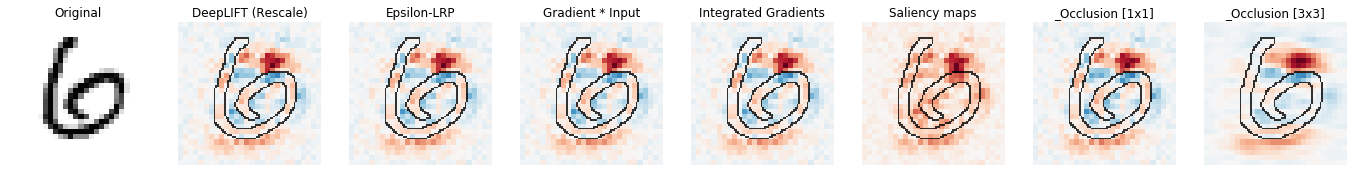

In [25]:
# Import DeepExplain
from deepexplain.tensorflow import DeepExplain
from utils import plot, plt
%matplotlib inline

# Define the input to be tested
test_idx = 11
xi = test_x[[test_idx]]
yi = test_y[test_idx] 


# Create a DeepExplain context. 
# IMPORTANT: the network must be created within this context.
# In this example we have trained the network before, so we call `model(X)` to 
# recreate the network graph using the same weights that have been already trained.
with DeepExplain(session=sess) as de:
    logits = model(X)
    print(f'X.shape={X.get_shape()}')
    print(f'xi.shape={xi.shape}')
    print(f'yi.shape={yi.shape}')
    print(f'logits.shape={logits.get_shape()}')

    # We run `explain()` several time to compare different attribution methods
    attributions = {
        # Gradient-based
        'Saliency maps':        de.explain('saliency', tf.multiply(logits, yi), X, xi),
        'Gradient * Input':     de.explain('grad*input', logits * yi, X, xi),
        'Integrated Gradients': de.explain('intgrad', logits * yi, X, xi),
        'Epsilon-LRP':          de.explain('elrp', logits * yi, X, xi),
        'DeepLIFT (Rescale)':   de.explain('deeplift', logits * yi, X, xi),
        #Perturbation-based
        '_Occlusion [1x1]':      de.explain('occlusion', logits * yi, X, xi),
        '_Occlusion [3x3]':      de.explain('occlusion', logits * yi, X, xi, window_shape=(3,))
    }
    print ('Done')

# Plot attributions
n_cols = len(attributions) + 1
fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(3*n_cols, 3))
plot(xi.reshape(28, 28), cmap='Greys', axis=axes[0]).set_title('Original')
for i, method_name in enumerate(sorted(attributions.keys())):
    plot(attributions[method_name].reshape(28,28), xi = xi.reshape(28, 28), axis=axes[1+i]).set_title(method_name)